In [23]:


#!jupyter nbconvert --output-dir='./results/' --to pdf --no-input umda-pbil-geneticnds-mimic-feda.ipynb  # pdf, html, latex


In [24]:


import json
import pandas as pd
import re
import numpy as np


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'gdplus','time','nds_update_time']

datasets_names = ['p1', 'p2', 's1', 's2', 's3']  
algorithms = ['GRASP', 'umda', 'pbil', 'geneticNDS'] 

files_container = '../output/files_list_soco_umda-pbil-GRASP-geneticnds' # #  generated by running extract_postMetrics.py



In [25]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI'])

for name in datasets_names:
    
    ds = Dataset(source_file='..\datasets\\'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

        
    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis}
    ds_summary = ds_summary.append(new_row, ignore_index=True)

def row_color(val):
    
    if val < 2: color = 'background-color: yellow'

    return color


pd.set_option('display.float_format', '{:.3f}'.format)
display(ds_summary)
#print(ds_summary[0:17].to_latex(index=False))



,Dataset,#Stakeholders,#PBI
0,p1,5,20
1,p2,5,100
2,s1,15,40
3,s2,50,80
4,s3,100,140


In [26]:
import math

def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            parameters_dictios_list.append(dictio['parameters'])
            metrics_dictios_list.append(dictio['metrics'])
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    
    metrics_df = metrics_df[keep_metrics]
    #lists = metrics_df['gdplus']
    #for l in lists:
     #   for x in l:
      #      if isinstance(x, str): print(x, l)

    
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        #metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist())
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)
    #display(metrics_df)
    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=files

    return combined_df

In [27]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [28]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [29]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

In [30]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [31]:
def get_files_for_dataset(dataset_name):
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            # todo: al haber metido en files_list los geneticos, resulta que tienen "p1" en todos los nombres por 'flip1bit', y elitismnds30 con s3.
            temp_line = line.replace("flip1bit", '')
            temp_line = temp_line.replace("elitismnds30", '')
            if dataset_name in temp_line: 
                files.append('../'+str(line.replace('\n','')))
    return files

## 2. Search of the best hyperparameters configuration for each algorithm, given SSS_per_iteration={False,True}

### 2.1 Best configuration for: GRASP


In [32]:
#filest_list_GRASP contains all output files from the GRASP algorithm. Goal is to find the best hyperparameters configuration.
# 
algorithm =  'GRASP'
if('GRASP' in files_container):

    keep_parameters = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode','sss_per_iteration']
    

    files = []
    with open(files_container, 'r') as f:
        for line in f:
             if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    
    df_grasp = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_grasp = df_grasp[df_grasp.dataset.isin(datasets_names)]
    
    print_hyperparams_values(df_grasp, keep_parameters, "GRASP")

    #display(df_grasp)
    best_for_grasp_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    values_sss = [False, True]
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_grasp.loc[df_grasp['sss_per_iteration'] == values_sss[it]]

        best_config_grasp, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
     
        best_for_grasp_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)

        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")


        display(best_for_grasp_df[it].drop(['file'], axis=1, inplace=False))


        print(f"\nBest hyperparameter configuration for GRASP when sss_per_iteration={values_sss[it]}:")
        for param in best_config_grasp:
            print(f"{param}:{best_config_grasp[param]}")



    




These are the different values used to set hyperparameters in GRASP, for each dataset:
solutions_per_iteration: [ 100  200  500  700 1000]
iterations: [ 50 100 200 300 400]
init_type: ['stochastically']
local_search_type: ['best_first_neighbor_random_domination']
path_relinking_mode: [None 'after_local']
sss_per_iteration: [ True False]
In total, 100 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,datasets,HV,wins
0,100,50,stochastically,best_first_neighbor_random_domination,after_local,False,[p1],[0.9931],1.000
1,200,300,stochastically,best_first_neighbor_random_domination,after_local,False,"[p2, s2]","[0.8869, 0.8175]",2.000
2,100,200,stochastically,best_first_neighbor_random_domination,after_local,False,[s1],[0.8867],1.000
3,500,50,stochastically,best_first_neighbor_random_domination,after_local,False,[s3],[0.8626],1.000



Best hyperparameter configuration for GRASP when sss_per_iteration=False:
solutions_per_iteration:200
iterations:300
init_type:stochastically
local_search_type:best_first_neighbor_random_domination
path_relinking_mode:after_local
sss_per_iteration:False

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,datasets,HV,wins
0,100,200,stochastically,best_first_neighbor_random_domination,None,True,[p1],[0.9931],1.000
1,700,100,stochastically,best_first_neighbor_random_domination,after_local,True,[p2],[0.8877],1.000
2,500,200,stochastically,best_first_neighbor_random_domination,after_local,True,[s1],[0.8869],1.000
3,200,400,stochastically,best_first_neighbor_random_domination,after_local,True,[s2],[0.819],1.000
4,700,50,stochastically,best_first_neighbor_random_domination,after_local,True,[s3],[0.8688],1.000



Best hyperparameter configuration for GRASP when sss_per_iteration=True:
solutions_per_iteration:700
iterations:50
init_type:stochastically
local_search_type:best_first_neighbor_random_domination
path_relinking_mode:after_local
sss_per_iteration:True


### 2.2 Best configuration for: GeneticNDS


In [33]:
# files_container contains all output files from the geneticNDS algorithm. Goal is to find the best hyperparameters configuration.
algorithm =  'geneticNDS'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']
#files_container = '../output/filest_list_geneticnds'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_genetic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_genetic = df_genetic[df_genetic.dataset.isin(datasets_names)]
print_hyperparams_values(df_genetic, keep_parameters, "GeneticNDS")

#display(df_genetic)
best_for_geneticnds_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_genetic.loc[df_genetic['sss_per_iteration'] == values_sss[it]]

    best_config_geneticNDS, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')

    best_for_geneticnds_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")

    display(best_for_geneticnds_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for GeneticNDS is:")
    for param in best_config_geneticNDS:
        print(f"{param}:{best_config_geneticNDS[param]}")


    print(best_for_geneticnds_df[it].drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))
        



These are the different values used to set hyperparameters in GeneticNDS, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1 0.3]
mutation: ['flip1bit']
replacement: ['elitismnds']
sss_per_iteration: [ True False]
In total, 100 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,wins
0,1000,100,2,0.8,0.3,flip1bit,elitismnds,False,"[p1, s2]","[0.9615, 0.6854]",2.000
1,1000,400,2,0.8,0.3,flip1bit,elitismnds,False,[p2],[0.7158],1.000
2,1000,300,2,0.8,0.3,flip1bit,elitismnds,False,"[s1, s3]","[0.7846, 0.6841]",2.000



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:300
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:False
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & mutation\_prob & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &             100 &           0.3 &             False & [p1, s2] & [0.9615, 0.6854] & 2.000 \\
             1000 &             400 &           0.3 &             False &     [p2] &         [0.7158] & 1.000 \\
             1000 &             300 &           0.3 &             False & [s1, s3] & [0.7846, 0.6841] & 2.000 \\
\bottomrule
\end{tabular}


Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least con

,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,wins
0,1000,100,2,0.8,0.3,flip1bit,elitismnds,True,"[p1, s2]","[0.9615, 0.6849]",2.000
1,1000,400,2,0.8,0.3,flip1bit,elitismnds,True,[p2],[0.7153],1.000
2,1000,300,2,0.8,0.3,flip1bit,elitismnds,True,"[s1, s3]","[0.7842, 0.6839]",2.000



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:300
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & mutation\_prob & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &             100 &           0.3 &              True & [p1, s2] & [0.9615, 0.6849] & 2.000 \\
             1000 &             400 &           0.3 &              True &     [p2] &         [0.7153] & 1.000 \\
             1000 &             300 &           0.3 &              True & [s1, s3] & [0.7842, 0.6839] & 2.000 \\
\bottomrule
\end{tabular}



### 2.3 Best configuration for: UMDA



In [34]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
algorithm = 'umda'
keep_parameters = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme','sss_per_iteration']

#files_container = '../output/filest_list_umda'

files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_umda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_umda = df_umda[df_umda.dataset.isin(datasets_names)]
print_hyperparams_values(df_umda, keep_parameters, "UMDA")
#display(df_umda)

best_for_umda_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_umda.loc[df_umda['sss_per_iteration'] == values_sss[it]]
    best_config_umda, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_umda_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")


    display(best_for_umda_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for UMDA when sss_per_iteration={values_sss[it]}:")
    for param in best_config_umda:
        print(f"{param}:{best_config_umda[param]}")


    print(best_for_umda_df[it].drop(['file', 'replacement_scheme','selection_scheme'], axis=1, inplace=False).to_latex(index=False))

These are the different values used to set hyperparameters in UMDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_scheme: ['nds']
replacement_scheme: ['elitism']
sss_per_iteration: [ True False]
In total, 50 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,wins
0,1000,50,nds,elitism,False,"[p1, s3]","[0.9836, 0.7913]",2.000
1,1000,100,nds,elitism,False,[p2],[0.8193],1.000
2,1000,400,nds,elitism,False,"[s1, s2]","[0.8542, 0.7782]",2.000



Best hyperparameter configuration for UMDA when sss_per_iteration=False:
population_length:1000
max_generations:400
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:False
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &              50 &             False & [p1, s3] & [0.9836, 0.7913] & 2.000 \\
             1000 &             100 &             False &     [p2] &         [0.8193] & 1.000 \\
             1000 &             400 &             False & [s1, s2] & [0.8542, 0.7782] & 2.000 \\
\bottomrule
\end{tabular}


Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum co

,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,wins
0,1000,50,nds,elitism,True,"[p1, s3]","[0.9835, 0.7897]",2.000
1,1000,100,nds,elitism,True,[p2],[0.8176],1.000
2,1000,400,nds,elitism,True,"[s1, s2]","[0.8542, 0.7768]",2.000



Best hyperparameter configuration for UMDA when sss_per_iteration=True:
population_length:1000
max_generations:400
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:True
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &              50 &              True & [p1, s3] & [0.9835, 0.7897] & 2.000 \\
             1000 &             100 &              True &     [p2] &         [0.8176] & 1.000 \\
             1000 &             400 &              True & [s1, s2] & [0.8542, 0.7768] & 2.000 \\
\bottomrule
\end{tabular}



### 2.4 Best configuration for: PBIL


In [35]:
algorithm = 'pbil'
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift','sss_per_iteration']

#files_container = '../output/filest_list_pbil'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_pbil = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_pbil = df_pbil[df_pbil.dataset.isin(datasets_names)]
print_hyperparams_values(df_pbil, keep_parameters, "PBIL")
#display(df_pbil)
best_for_pbil_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_pbil.loc[df_pbil['sss_per_iteration'] == values_sss[it]]
    best_config_pbil, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_pbil_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")
    display(best_for_pbil_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for PBIL is:")
    for param in best_config_pbil:
        print(f"{param}:{best_config_pbil[param]}")

    print(best_for_pbil_df[it].drop(['file', 'learning_rate','mutation_prob', 'max_evaluations',
    'mutation_shift'], axis=1, inplace=False).to_latex(index=False))







These are the different values used to set hyperparameters in PBIL, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
learning_rate: [0.1]
mutation_prob: [0.1]
mutation_shift: [0.1]
sss_per_iteration: [ True False]
In total, 50 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,wins
0,1000,400,0,0.1,0.1,0.1,False,"[p1, p2, s1, s3]","[0.9908, 0.6018, 0.81, 0.5442]",4.000
1,500,400,0,0.1,0.1,0.1,False,[s2],[0.5891],1.000



Best hyperparameter configuration for PBIL is:
population_length:1000
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:False
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &         datasets &                             HV &  wins \\
\midrule
             1000 &             400 &             False & [p1, p2, s1, s3] & [0.9908, 0.6018, 0.81, 0.5442] & 4.000 \\
              500 &             400 &             False &             [s2] &                       [0.5891] & 1.000 \\
\bottomrule
\end{tabular}


Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,wins
0,1000,400,0,0.1,0.1,0.1,True,"[p1, p2, s1, s2]","[0.9929, 0.7011, 0.8423, 0.6695]",4.000
1,700,400,0,0.1,0.1,0.1,True,[s3],[0.6093],1.000



Best hyperparameter configuration for PBIL is:
population_length:1000
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:True
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &         datasets &                               HV &  wins \\
\midrule
             1000 &             400 &              True & [p1, p2, s1, s2] & [0.9929, 0.7011, 0.8423, 0.6695] & 4.000 \\
              700 &             400 &              True &             [s3] &                         [0.6093] & 1.000 \\
\bottomrule
\end{tabular}



### 2.5 Best configuration for: MIMIC

In [36]:
if('mimic' in files_container):

    algorithm = 'mimic'
    keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals']




    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    df_mimic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_mimic = df_mimic[df_mimic.dataset.isin(datasets_names)]
    print_hyperparams_values(df_mimic, keep_parameters, "MIMIC")
    #display(df_mimic)
    best_for_mimic_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    values_sss = [False, True]
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_mimic.loc[df_mimic['sss_per_iteration'] == values_sss[it]]
        best_config_mimic, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
        best_for_mimic_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")
        display(best_for_mimic_df[it].drop(['file'], axis=1, inplace=False))

        print(f"\nBest hyperparameter configuration for MIMIC is:")
        for param in best_config_mimic:
            print(f"{param}:{best_config_mimic[param]}")

       



## 3. Timing

#### 3.1 Total time of algorithms and what part is used for updating the NDS_archive

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: p1.
GRASP: 50.19%
umda: 68.32%
pbil: 84.96%
geneticNDS: 90.69%


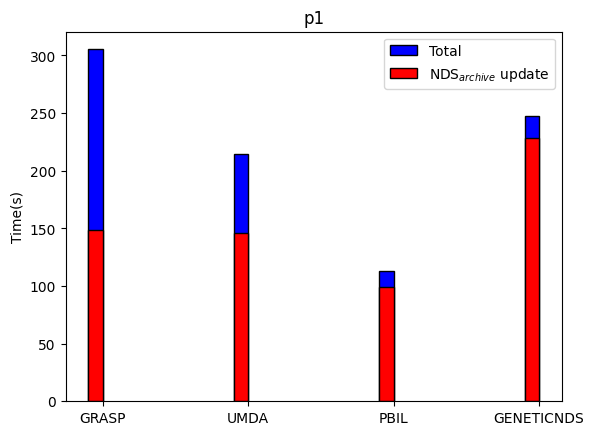

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: p2.
GRASP: 36.34%
umda: 79.36%
pbil: 86.46%
geneticNDS: 94.26%


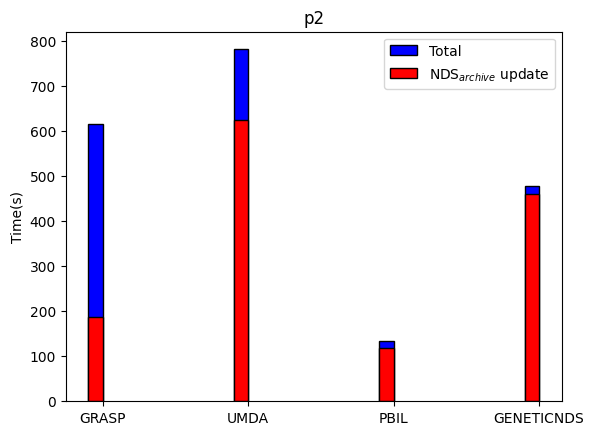

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s1.
GRASP: 54.22%
umda: 75.88%
pbil: 88.98%
geneticNDS: 95.22%


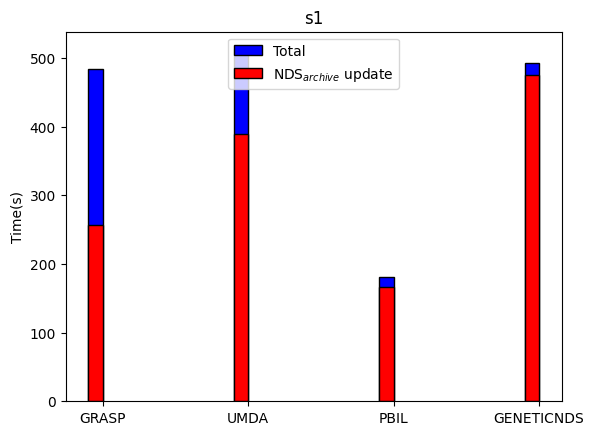

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s2.
GRASP: 45.69%
umda: 83.49%
pbil: 89.53%
geneticNDS: 96.96%


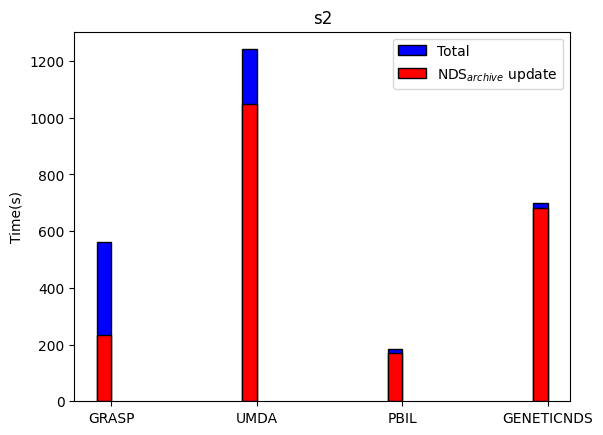

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s3.
GRASP: 39.19%
umda: 78.78%
pbil: 87.37%
geneticNDS: 96.0%


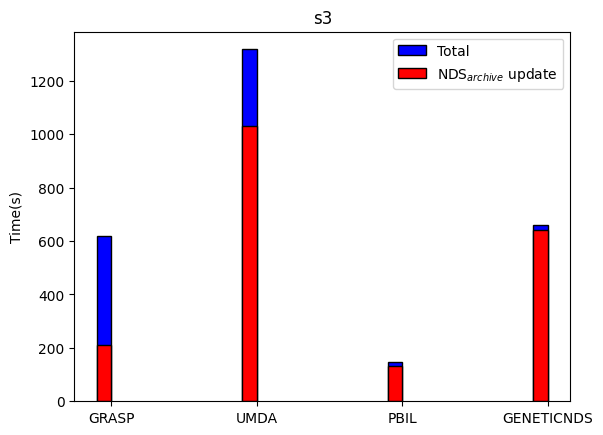

In [37]:
import matplotlib.pyplot as plt

keep_parameters = ['algorithm','sss_per_iteration']
for dataset in datasets_names:
    
    files = []
    files = get_files_for_dataset(dataset)
    df_dataset = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    #only keep executions which perform SSS once at the end
    df_dataset_noSSS = df_dataset.loc[df_dataset['sss_per_iteration']==False]

    width = 0.1
    r = np.arange(len(algorithms))
    print(f'Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: {dataset}.')
    for i in np.arange(0, len(algorithms)):
        df_method=df_dataset_noSSS.loc[df_dataset_noSSS['algorithm']==algorithms[i]]
        mean_total_time = np.mean(df_method['time'])
        mean_nds_update__time = np.mean(df_method['nds_update_time'])
        percents = (df_method['nds_update_time']*100)/df_method['time'] 
        mean_percents = np.mean(percents)
        plt.bar(i,mean_total_time , color = 'b', width = width, edgecolor = 'black', label="Total")
        plt.bar(i,mean_nds_update__time , color = 'r', width = width, edgecolor = 'black',  label=r"NDS$_{archive}$ update")
        print(f'{algorithms[i]}: {round(mean_percents,2)}%')
    plt.title(dataset)
    plt.ylabel("Time(s)")
    plt.xticks(r + width/2,[x.upper() for x in algorithms])
    #remove repeated legend labels
    handles, labels = plt.gca().get_legend_handles_labels() 
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

#display(df_method)



#### 3.2 Total time with SSS once Vs Total time with SSS per iteration

In [40]:
def get_time_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, differences, percents): #at this point, filtered_df only has 2 rows: one with SSS per it = True and other False.
    if filtered_df.shape[0]==2: #si no hay 2 es pq un experimento aún no haya acabado
        x1 = filtered_df[filtered_df.sss_per_iteration == True].iloc[0]['time'] # get first (and only) row with this column to True
        x2 = filtered_df[filtered_df.sss_per_iteration == False].iloc[0]['time'] # get first (and only) row with this column to False
        with_SSS_per_it = with_SSS_per_it + [x1]
        with_SSS_at_end = with_SSS_at_end + [x2]
        differences =  differences + [x2 - x1]
        percents = percents + [((x2-x1)*100)/x2]
    return with_SSS_per_it, with_SSS_at_end, differences, percents

Mean percentage of time reduction after using SSS per iteration:
GRASP: 4.53%
UMDA: 17.99%
PBIL: 27.35%
GeneticNDS: 58.69%


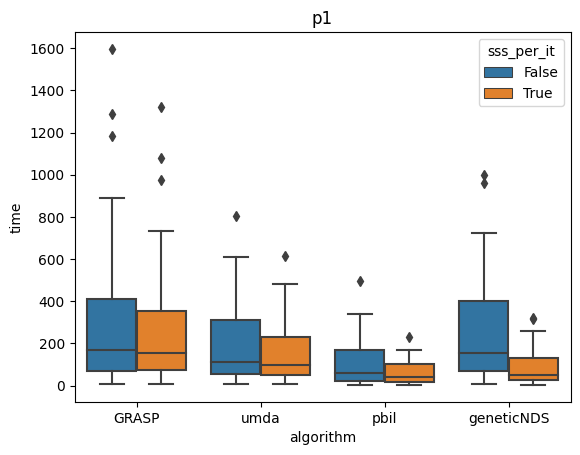

Mean percentage of time reduction after using SSS per iteration:
GRASP: 8.75%
UMDA: 43.6%
PBIL: 50.91%
GeneticNDS: 68.12%


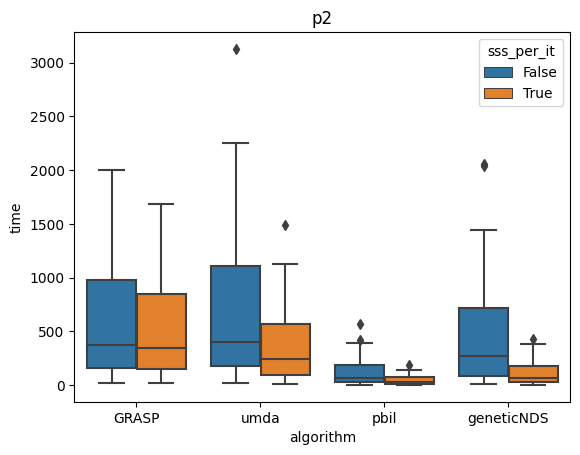

Mean percentage of time reduction after using SSS per iteration:
GRASP: 19.14%
UMDA: 35.35%
PBIL: 49.33%
GeneticNDS: 73.12%


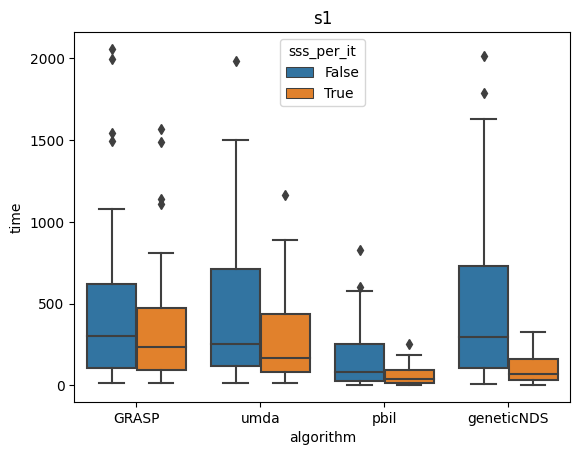

Mean percentage of time reduction after using SSS per iteration:
GRASP: 12.95%
UMDA: 56.16%
PBIL: 49.96%
GeneticNDS: 80.76%


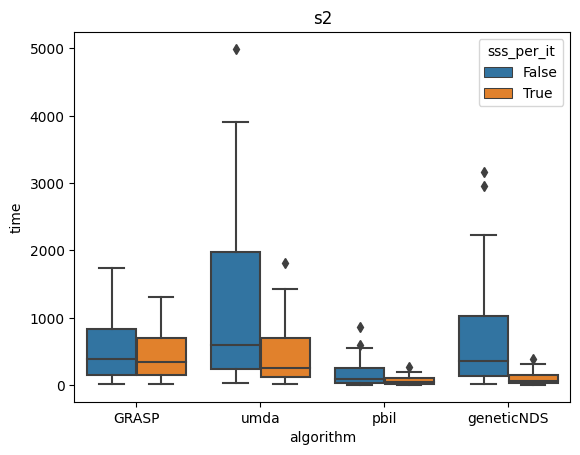

Mean percentage of time reduction after using SSS per iteration:
GRASP: 11.01%
UMDA: 45.76%
PBIL: 55.11%
GeneticNDS: 74.38%


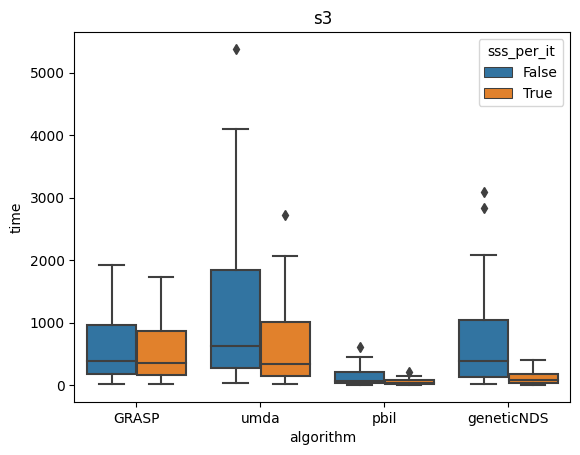

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


grasp_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "iterations", "solutions_per_iteration", "path_relinking_mode"]
pbil_umda_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations"]
geneticnds_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations", 'mutation_prob']


for dataset in datasets_names:
    files = get_files_for_dataset(dataset)
    boxplot_df = pd.DataFrame(columns=['algorithm', 'sss_per_it', 'time'])
    percents_grasp, percents_umda, percents_pbil, percents_genetic= ([] for i in range(4)) #reduction percentage over the original time with SSS_per_it=FAlse
    for temp_alg in algorithms: 
        if temp_alg in ["pbil","umda"]:
           hyp = pbil_umda_hyperparams
        if temp_alg=="GRASP":
            hyp = grasp_hyperparams
        if temp_alg=="geneticNDS":
            hyp = geneticnds_hyperparams
        
        df_dataset = getdf_with_params_and_metrics(files=files, keep_parameters=hyp)
        df_alg = df_dataset.loc[df_dataset['algorithm']==temp_alg]
        
        
        differences_grasp, differences_umda, differences_pbil, differences_genetic= ([] for i in range(4))
        
        with_SSS_per_it_grasp,with_SSS_per_it_umda,with_SSS_per_it_pbil,with_SSS_per_it_genetic= ([] for i in range(4)) # para gráfico de cajas, y tests estadísticos pareados paramétricos
        with_SSS_at_end_grasp,with_SSS_at_end_umda,with_SSS_at_end_pbil,with_SSS_at_end_genetic= ([] for i in range(4))
        if temp_alg=="GRASP":
            for it1 in df_alg["iterations"].unique():
                for it2 in df_alg["solutions_per_iteration"].unique():
                    for it3 in df_alg["path_relinking_mode"].unique():
                        filtered_df = df_alg[(df_alg['iterations']==it1) & (df_alg['solutions_per_iteration']==it2) & (df_alg['path_relinking_mode']==it3)]
                        if it3==None:
                            filtered_df = df_alg[(df_alg['iterations']==it1) & (df_alg['solutions_per_iteration']==it2) & (df_alg['path_relinking_mode'].isna())]
                        with_SSS_per_it_grasp, with_SSS_at_end_grasp, differences_grasp,percents_grasp = get_time_differences(filtered_df, with_SSS_per_it_grasp, with_SSS_at_end_grasp, differences_grasp,percents_grasp)
            for temp_time in with_SSS_at_end_grasp:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': False, 'time':temp_time}, ignore_index=True)
            for temp_time in with_SSS_per_it_grasp:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': True, 'time':temp_time}, ignore_index=True)
            
        
        #print(f"{temp_alg} differences and mean with {dataset}:", differences, np.mean(differences))
        
        
        if temp_alg =="pbil":
            for it1 in df_alg["population_length"].unique():
                for it2 in df_alg["max_generations"].unique():
                        filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2)]
                        with_SSS_per_it_pbil, with_SSS_at_end_pbil, differences_pbil, percents_pbil = get_time_differences(filtered_df, with_SSS_per_it_pbil, with_SSS_at_end_pbil, differences_pbil,percents_pbil)
            for temp_time in with_SSS_at_end_pbil:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': False, 'time':temp_time}, ignore_index=True)
            for temp_time in with_SSS_per_it_pbil:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': True, 'time':temp_time}, ignore_index=True)
            
                  

        if temp_alg =="umda":
            for it1 in df_alg["population_length"].unique():
                for it2 in df_alg["max_generations"].unique():
                        filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2)]
                        with_SSS_per_it_umda, with_SSS_at_end_umda, differences_umda, percents_umda = get_time_differences(filtered_df, with_SSS_per_it_umda, with_SSS_at_end_umda, differences_umda,percents_umda)
            for temp_time in with_SSS_at_end_umda:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': False, 'time':temp_time}, ignore_index=True)
            for temp_time in with_SSS_per_it_umda:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': True, 'time':temp_time}, ignore_index=True)

        if temp_alg == "geneticNDS":
            for it1 in df_alg["population_length"].unique():
                for it2 in df_alg["max_generations"].unique():
                    for it3 in df_alg["mutation_prob"].unique():
                        filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2) & (df_alg['mutation_prob']==it3)]
                        with_SSS_per_it_genetic, with_SSS_at_end_genetic, differences_genetic, percents_genetic = get_time_differences(filtered_df, with_SSS_per_it_genetic, with_SSS_at_end_genetic, differences_genetic,percents_genetic)
            for temp_time in with_SSS_at_end_genetic:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': False, 'time':temp_time}, ignore_index=True)
            for temp_time in with_SSS_per_it_genetic:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': True, 'time':temp_time}, ignore_index=True)
                        
   
    print("Mean percentage of time reduction after using SSS per iteration:")
    print(f"GRASP: {round(np.mean(percents_grasp),2)}%")
    print(f"UMDA: {round(np.mean(percents_umda),2)}%")
    print(f"PBIL: {round(np.mean(percents_pbil),2)}%")
    print(f"GeneticNDS: {round(np.mean(percents_genetic),2)}%")
    sns.boxplot(x="algorithm", hue="sss_per_it", y="time", data=boxplot_df).set(title=dataset)
    plt.show()
   

    
    
    
    

    

### 3.2 Diferencia en la media de tiempo, hv y gd+: para cada dataset, juntando todos los algoritmos.

## 4. Pareto plots for each dataset, setting each algorithm with its best configuration found (wins among all datasets).
Given the most frequently best configuration (over all datasets), we plot the pareto for each dataset given that configuration. That is, the configuration for a given algorithm is the same acrooss all datasets, concretely the one which performed the best more times (more wins).

We show a plot for each dataset. In each plot, for each algorithm, we show the pareto front found in all the executions (commonly 30). Since the solutions subset size is commonly 10, thus for each algorithm we plot 300 points. Since each algorithm has 30 paretos, please note that such paretos are not non-dominated among them, which can be seen in the  shapes they create.

#### 4.1 Metrics

We show the average results over 30 executions for each algorithm. Each execution produces a NDS, from wich we keep the subset of 10 solutions which maximize HV, as suggested in 'Difficulties in Fair Performance Comparison of Multi-Objective Evolutionary Algorithms'. Such a subset is constructed by following an incremental forward greedy search. 

Metrics shown are: 4 Quality Indiciators (HV, gd+, UNFR, spread), time and cardinality of the global NDS found by the algorithm during execution.

- HV (Hypervolume): this is the most widely used metric to assess paretos solutions for multi-objective problems and, concretly, in SBSE. It summarizes the four aspects of a solution set (convergence, spread, uniformity and cardinality); that is, this metric can be used as a compliance metric representing how good a Pareto front is. HV tends to be greater as knee points in the pareto are neareer the optimal point (0,0), thus it is preferable when Decision Makers prefer balanced solutions. In order to compute it, a reference point is needed, and this should be the same for all algorithms under comparison. Following the results and suggestions in ("How to evaluate solutions in pareto-based search-bases software engin."), we set the following reference point in our bi-objective problem:
                            $ref_x = nadir_x + range_x/10$ 
                            $ref_y = nadir_y + range_y/10$
The nadir point is the worst point found by algorithms during search. Since we normalize both cost and satisfaction, our worst point is 1 for both metrics (satisfaction is plotted as $1-satisfaction$). Range is the difference between the best and worst point found. Best point is 0, so clearly the value of the reference point for both goals is $1 + (1-0)/10 = 1.1$. HV is pareto compliance, so $HV_a > HV_b$ means that, visually, the pareto front of algorithm $a$ dominates algorithm $b$. A great advantage of HV is that it does not need an ideal Pareto Reference, so its computation and fair comparison with other algorithm only needs a shared reference point which, thanks to goals normalization, is known a priori.

- GD+: General Distance (GD) covers the convergence aspect of the quality of solution set, measuring the Euclidian distance of such solution set to the ideal Pareto Reference. For each solution, its GD is the minimum of the distances to each point in the PF. In order to become GD compliant with Pareto dominance, GD+ enhances GD by measuring distances between points using only the goal coordinates which are superior in the Pareto Reference than those from the solutions set being measured. This metric is to be minimized, and a key point is the computation of the Pareto Reference, which needs to be done after execution of search algorithms. In our experiments, Pareto Reference is constructed by finding the Non Dominated Solutions set among all solutions sets found by all algorithm, under all hyperparameters configurations explained in Section 2. 

- UNFR: Unique Non Dominated Front Ratio. It measures the ratio of solutio points in the PR which belong to the solution set of the evaluated algorithm. That is, it measures the contribution (from to 0 to 1) of an algorithm to the PR. Of curse, a point in the PR might be present in the solution sets of several algorithms. In our case, since the PR is constructed from such a large number of algorithms and configuration combinations, it presents a high cardinality of solutions. Furthermore, since each algorithm is evaluated using only using a selected subset of 10 points from its solution set, the UNFR value for each algorithm tends to be quite low, and the maximum possible is never 1, since the PR contais further more than 10 points. Anyway, greater UNFR values is desiderable. 




#### 4.2 Results

Here we show one plot pero datasets, containing the result of all algorithms with their best configuration. As mentioned before, each algorithm is run 30 times; afeter each execution, we keep a subset of the NDS constructed. This subset contains the 10 solutions from NDS which maximize HV in a forward greedy search over the NDS. Thus, for each algorithm, we plot 10*30=300 points. This way, it is easy to identify the common pareto shape relative to the algorithm. After each plot, all metrics are tabbed to show the average over the 30 executions in the dataset.

It is worth to mention that half of the execution time in algorithms is due to updating NDS after each iteration. Thus, although after each execution we select a subset of 10 solutions in the final NDS, more time consuming algorithms are usually those which tend to develop a NDS with higher cardinality suring their search.


In [ ]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [ ]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#algorithms = ['GRASP', 'umda', 'pbil']  # MIMIC, GRASP (feda in inserted automatically)
#display(best_for_grasp_df)


files_all_algorithms =[ #call with best_for_... in the same order than algorithms in list algorithms above
    get_files_list_with_best_configuration(best_for_grasp_df[0],datasets_names), # [0] is sss_per_it =false
    get_files_list_with_best_configuration(best_for_grasp_df[1],datasets_names),
    get_files_list_with_best_configuration(best_for_umda_df[0],datasets_names),
    get_files_list_with_best_configuration(best_for_umda_df[1],datasets_names),
    get_files_list_with_best_configuration(best_for_pbil_df[0],datasets_names),
    get_files_list_with_best_configuration(best_for_pbil_df[1],datasets_names)
]





wins_counts = {}
wins_counts_unfr = {}
wins_counts_gd = {}
wins_counts_spread = {}
wins_datasets = {}
for alg in algorithms:
    wins_counts[alg] = 0
    wins_datasets[alg] = []
    wins_counts_unfr[alg] = 0
    wins_counts_gd[alg] = 0
    wins_counts_spread[alg] = 0
 

# print 30 (or the number of execution) paretos of each dataset
# (maybe one plot per dataset, and all differente algorithms in each plot)

latex_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
for i in range(0,len(datasets_names)):
    fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
    #ax =fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(121)
    ax.set_xlabel('Cost')
    ax.set_ylabel('1 - Satisfaction')
    print(datasets_names[i])
   # ax.set_title(datasets_names[i])
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
    
    for j in range(0,len(algorithms)):    
        try:
            file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
            with open(file, 'r') as f:
                dictio = json.load(f)
            paretos_list = dictio['paretos']
            dataset = dictio['parameters']['dataset']
            metrics = dictio['metrics']
            pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
            
            (hv, unfr, gdplus, spread, time, nds) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'], metrics['NDS_size'])
            new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=4), 'UNFR':np.mean(unfr).round(decimals=4), 'gd+':np.mean(gdplus).round(decimals=4),
             'spread':np.mean(spread).round(decimals=4), 'time(s)':np.mean(time).round(decimals=4), '|NDS|':np.mean(nds).round(decimals=4)}
            
            for pareto in paretos_list: 
                x = [item[0] for item in pareto]
                y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                plt.scatter(x, y, color='C'+str(j), alpha=0.4, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                    
            
            summary_df = summary_df.append(new_row, ignore_index=True)
        except(FileNotFoundError, IOError):
            print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
        
    
    # update wins counts in HV
    idx = summary_df['HV'].idxmax()
    winner = summary_df.loc[idx]['Method']
    wins_counts[winner] = wins_counts[winner] + 1
    wins_datasets[winner].extend([datasets_names[i]])

    # update wins counts in UNFR
    idx_unfr = summary_df['UNFR'].idxmax()
    winner_unfr = summary_df.loc[idx_unfr]['Method']
    wins_counts_unfr[winner_unfr] = wins_counts_unfr[winner_unfr] + 1
    

    # update wins counts in gd+
    idx_gd = summary_df['gd+'].idxmin()
    winner_gd = summary_df.loc[idx_gd]['Method']
    wins_counts_gd[winner_gd] = wins_counts_gd[winner_gd] + 1


    # update wins counts in spread
    idx_spread = summary_df['spread'].idxmin()
    winner_spread = summary_df.loc[idx_spread]['Method']
    wins_counts_spread[winner_spread] = wins_counts_spread[winner_spread] + 1

    # print pareto reference
    print(f"Pareto Reference has {len(pareto_reference)} points")
    max_unfr = len(pareto) / len(pareto_reference)
    print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")
    x = [item[0] for item in pareto_reference]
    y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
    
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    
    #plt.scatter(x, y, color='black', alpha=0.3, edgecolors='none', label='ParetoRef', marker='_') 
    plt.plot(x,y, linestyle="--", linewidth=1, color='black')


    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    values = list(by_label.values())
    values = [Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='PRef')] + values
    legend_keys=[r"GA" if s =="geneticNDS" else s for s in by_label.keys()]
    
    legend_keys= ["PRef"] + legend_keys

    plt.legend(values,legend_keys )        
    #plt.legend(by_label.values(), ["GA", "UMDA", "PBIL", "FEDA","ParetoRef"])        
    


    plt.savefig("images/scatter_"+datasets_names[i]+".svg")
    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df) # print in copy-paste format
    latex_df = latex_df.append(summary_df)
    print("---------------------------------------------------------------")
    

latex_df = latex_df.drop(columns=['time(s)'])
print("Wins Counts:") 
print(wins_counts)
print("Wins in datasets:")
print(wins_datasets)

print("Wins Counts UNFR:") 
print(wins_counts_unfr)
print("Wins Counts GD+:") 
print(wins_counts_gd)
print("Wins Counts Spread:") 
print(wins_counts_spread)
            
             






In [ ]:
pd.options.display.float_format = '{:.3f}'.format

edited_df = pd.DataFrame(latex_df)
edited_df[['|NDS|']] =  edited_df['|NDS|'].map("{:.1f}".format)


#display(edited_df)
#print(edited_df.to_latex(index=False))

In [ ]:
#plot HV for each algorithm, across datasets ordered by #pbi
# ['p1','a1','a2','c1','c2','p2','a3','a4','c3','c4','d3','d4','d6','d7']


ordered_by_pbis = [0,2,3,6,7,1,4,5,8,9,10,11,12,13] #index of datasets ordered by number of pbis

num_pbis = [20, 50, 50, 50, 50, 100, 200, 200, 200, 200, 200,200, 300, 300]


feda_values = latex_df[latex_df.Method=='FEDA'].HV.values[ordered_by_pbis]
umda_values = latex_df[latex_df.Method=='UMDA'].HV.values[ordered_by_pbis]
pbil_values = latex_df[latex_df.Method=='PBIL'].HV.values[ordered_by_pbis]
ga_values = latex_df[latex_df.Method=='geneticNDS'].HV.values[ordered_by_pbis]

#get mean hv by the datasets with same number of pbis
feda_five_values = [feda_values[0]] + [np.mean(feda_values[1:4])]+ [feda_values[5]] + [np.mean(feda_values[6:11])]+ [np.mean(feda_values[12:13])]
umda_five_values = [umda_values[0]] + [np.mean(umda_values[1:4])]+ [umda_values[5]] + [np.mean(umda_values[6:11])]+ [np.mean(umda_values[12:13])]
pbil_five_values = [pbil_values[0]] + [np.mean(pbil_values[1:4])]+ [pbil_values[5]] + [np.mean(pbil_values[6:11])]+ [np.mean(pbil_values[12:13])]
ga_five_values = [ga_values[0]] + [np.mean(ga_values[1:4])]+ [ga_values[5]] + [np.mean(ga_values[6:11])]+ [np.mean(ga_values[12:13])]


#plot mean value of hv given datasets with the same number of pbis
x_axis=[20, 50, 100, 200, 300]
plt.plot(x_axis, ga_five_values, color='blue', label=r'GA$^a$') 
plt.plot(x_axis, umda_five_values, color='orange', label=r'UMDA$^a$') 
plt.plot(x_axis, pbil_five_values, color='green', label=r'PBIL$^a$') 
plt.plot(x_axis, feda_five_values, color='red', label='FEDA') 
plt.xlabel("Number of Requirements")
plt.ylabel("Mean HV")
plt.xticks(x_axis)
plt.grid(b=None)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())    
plt.savefig("images/HV-algorithms.svg")
plt.show()


# see if the difference in HV increases with number of pbis

diff_ga = np.array(feda_five_values) - np.array(ga_five_values)
diff_umda = np.array(feda_five_values) - np.array(umda_five_values)
diff_pbil = np.array(feda_five_values) - np.array(pbil_five_values)

plt.plot(x_axis, diff_ga, color='blue', label=r'GA$^a$') 
plt.plot(x_axis, diff_umda, color='orange', label=r'UMDA$^a$') 
plt.plot(x_axis, diff_pbil, color='green', label=r'PBIL$^a$') 
plt.xlabel("Number of Requirements")
plt.ylabel("FEDA superiority in Hypervolume")
plt.xticks(x_axis)
plt.grid(b=None)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())    
plt.savefig("images/HV-difference.svg")
plt.show()






    